# Atomic Tools Library 
This jupyter notebook demonstrate different examples using ATL module. 

In [1]:
import atl # Atomic Tools Libary
import numpy as np
import matplotlib.pylab as plt
import pandas as pd

%matplotlib inline
plt.style.use('ggplot')
# print(plt.style.available)

## Reading lammps log file

In [6]:
data, tags = atl.read_log(filename="log.lammps", run=1)

print(tags)
print (data[:3])

['Step', 'Temp', 'TotEng', 'v_dens', 'v_E', 'v_K', 'v_P']
[[0.0, 1.0, -14.083351, 0.038165632, -0.021146172, 0.0029763344, -0.024122506], [1000.0, 46.526908, 65.932951, 0.038165632, 0.098998425, 0.13847964, -0.039481212], [2000.0, 50.68053, 85.817303, 0.038165632, 0.12885481, 0.1508422, -0.021987393]]


Index(['Step', 'Temp', 'TotEng', 'v_dens', 'v_E', 'v_K', 'v_P', 'Time'], dtype='object')


/home/hossein/anaconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


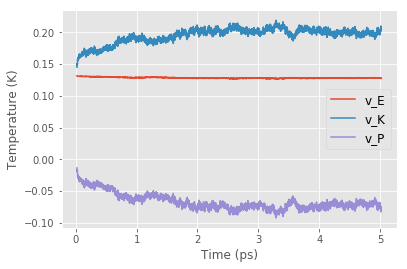

In [7]:
log = atl.read_log_pandas(filename="log.lammps", run=3) # reading into pandas
log['Time'] = 1E-6 * log['Step']

print(log.columns)

# log.plot('time','Temp')
log.plot('Time',['v_E', 'v_K', 'v_P'])

plt.ylabel('Temperature (K)')
plt.xlabel('Time (ps)')
plt.legend(fontsize=12)

## Reading .xyz file format

In [8]:
grn = atl.read_xyz_pandas('grn.xyz')
grn.head()

,t,x,y,z
0,C,-1.842003,-3.545019,0.0
1,C,-3.070027,-2.836020,0.0
2,C,-3.070027,-1.418020,0.0
3,C,-1.842003,-0.709021,0.0
4,C,0.614044,-3.545019,0.0


(-3.377033, 4.4219669999999995, -3.8995189999999997, 3.8994809999999998)

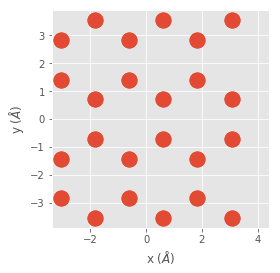

In [9]:
plt.plot(grn.x, grn.y, 'o', ms=15)

plt.ylabel('y ($\AA$)')
plt.xlabel('x ($\AA$)')
plt.axis('square')

## Smoothing data

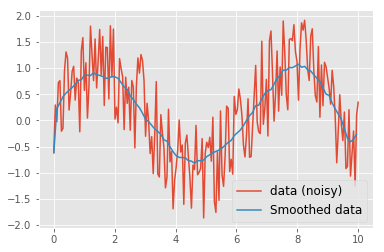

In [10]:
np.random.seed(1234)
x  = np.linspace(0.0,10.0,200)
y  = np.sin(x)+2*(np.random.rand(len(x))-0.5)
xs, ys = atl.smooth_data(x, y, n_ave=20, step=2)

plt.plot(x, y, label='data (noisy)')
plt.plot(xs, ys, label='Smoothed data')
plt.legend(fontsize=12)

## Molecular Frame
Modifying lammps input data file using *Molecular Frame* class

In [11]:
water = atl.MolecularFrame()
water.read_lmp('water.data') # reading lammps input file including atoms, bonds, angles, etc.

print ("Number of molecules:", water.n_molecules)
print ("Number of atoms:", water.n_atoms)
print ("Number of bonds:", water.n_bonds)
print ("Number of angles:", water.n_angles)
print ("Box: Lx(%1.2f) Ly(%1.2f) Lz(%1.2f)"%(water.lx, water.ly, water.lz))

Number of molecules: 293
Number of atoms: 879
Number of bonds: 586
Number of angles: 293
Box: Lx(15.00) Ly(31.00) Lz(22.00)


# Moving atoms

In [12]:
water.move_atoms([1.0, 1.0, 0.0])

### Center of mass & re-centering

In [13]:
print ("Center of mass:", water.center_of_mass)
water.recenter() # recentering to [0.0, 0.0, 0.0] (default)
print ("Center of mass:", water.center_of_mass)

Center of mass: [8.460467785745951, 20.44887050684226, 11.889981917376984]
Center of mass: [6.760163414868245e-14, 1.4015847906811192e-13, 8.585341409074158e-14]


### Selecting molecules in a specified region

In [14]:
def droplet(x, y, z):
    if (np.sqrt(x**2+y**2+z**2)<10.0):  # or adding "and (z>0.0):"
        return True # inside the region
    else: 
        return False # outside the region
    
water_droplet = water.select_molecules_in_region(region_func=droplet) # the region function as input argument
print ("Number of molecules (droplet):", water_droplet.n_molecules)

Number of molecules (droplet): 105


<img src="water_droplet.png" width="300">

### Randomly selected molecules

In [15]:
water_sel = water.select_molecules_randomly(nmol=water_droplet.n_molecules)
print ("Number of molecules (randomly selected):", water_droplet.n_molecules)

Number of molecules (randomly selected): 105


### Merging two molecules

In [16]:
# ... e.g. channel = clay + water

### Saving output molcular frame

In [17]:
water_droplet.write_xyz('droplet.out.xyz')

## Cross LJ parameters 
(suitable for LAMMPS)

In [18]:
clay_param={
    'ao':[70, 1.3297e-06, 4.27132],
    'st':[71, 1.8402e-06, 3.30196],
    'obc':[72, 0.155416, 3.1655200],
    'oh':[73, 0.155416, 3.1655200],     
    'ho':[74, 0.000000, 0.0000000],
    'mgo':[75, 9.0298e-07, 5.90900],
    'K': [76, 0.100000, 3.7423000],
    'hw':[77,0.000000, 0.0000000],
    'ow':[78, 0.155400, 3.5532000]
}
    
benzene_param={
    'H':[20, 2.829367882355780447E-02, 2.373408142809749322E+00],
    'C':[63, 7.345736105118740034E-02, 3.520525192477496734E+00]
}

In [19]:
# atl.intermol_lj_param(clay_param, benzene_param, ignore_self_interact=True)

## RDF calculations

### Import Fortran subroutine via f2py

In [5]:
import os
os.system("f2py -c ../atl/rdf_fort.f90 -m ../atl/rdf_fort")
import atl.rdf_fort 

### RDF wrapper

In [10]:
# without PBC
# atl.calculate_rdf(file_name='dump.xyz', sel_type=['2', '1'], pbc_box=[0, 0, 0], r_cutoff=9)

# PBC
atl.calculate_rdf(file_name='dump.xyz', sel_type=['1', '1'], pbc_box=[19.246222, 19.246222, 19.246222], r_cutoff=9,
                 lateral=True)

### Plot 

Text(0.5, 0, 'r ($\\AA$)')

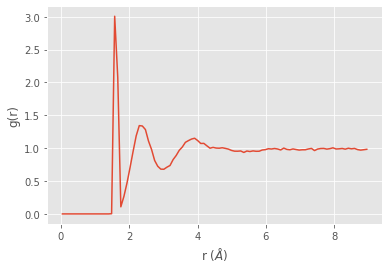

In [11]:
gr = np.loadtxt('gr.dat')
# print(gr)
plt.plot(gr[:,0], gr[:,1])

plt.ylabel('g(r)')
plt.xlabel(r'r ($\AA$)')

## Density-profile

In [1]:
import os
os.system("f2py -c ../atl/zden_fort.f90 -m ../atl/zden_fort")
import atl

In [2]:
atl.calculate_zden(file_name='dump.xyz', sel_type='2', zlim=[-15, 15], nz=200)

232.99999989000057


Text(0.5, 0, 'z ($\\AA$)')

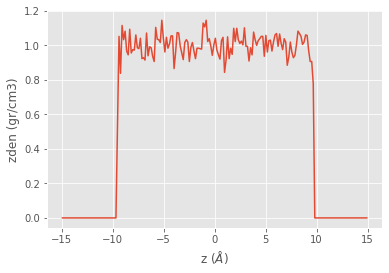

In [14]:
zden = np.loadtxt('zden.dat')

n_wat = np.sum(zden[:,1])*(zden[1,0]-zden[0,0])
print(n_wat)

mass_h2o = 18.02/6.023E23 # gr
area = 19.0**2 # A^2
rho = zden[:,1]/area*mass_h2o*1e24 # gr/cm^3

plt.plot(zden[:,0], rho)

plt.ylabel('zden (gr/cm3)')
plt.xlabel(r'z ($\AA$)')

# H-Bond

In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

import os
os.system("f2py -c ../atl/hbond_fort.f90 -m ../atl/hbond_fort")
import atl

In [2]:
atl.calculate_hbond(file_name='dump.xyz', sel_type=['2', '1', '2'], pbc_box=[19.246222, 19.246222, 19.246222],
                   criteria=[3.2, 2.5, 30.0], dump_angle=True, frames=[10, 10000, 1])

3.44241773962804


Text(0.5, 0, 'Frame')

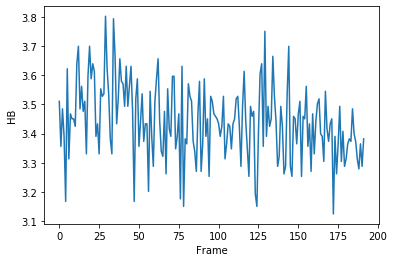

In [3]:
hb = np.loadtxt('hb.dat')
# print(gr)
hb_per_wat = hb[:,1]/hb[:,2]*2

plt.plot(hb_per_wat)

print(np.mean(hb_per_wat))

plt.ylabel('HB')
plt.xlabel('Frame')

/home/hossein/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


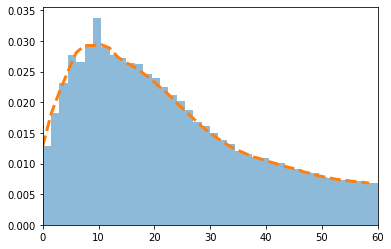

In [52]:
ang = np.loadtxt("angle.dat")

h = plt.hist(ang%90., bins=40, normed=True, range=(0, 60), alpha=0.5)
plt.xlim([0, 60])

x, y = atl.smooth_data(h[1][:-1], h[0], 3)
plt.plot(x, y, '--', lw=3)

## H-Bond Profile

In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

import os
os.system("f2py -c ../atl/hbond_profile_fort.f90 -m ../atl/hbond_profile_fort")
import atl

In [27]:
atl.calculate_hbond_profile(file_name='dump.xyz', sel_type=['2', '1', '2'], 
                            pbc_box=[19.246222, 19.246222, 19.246222],
                            criteria=[3.2, 2.4, 30.0], zlim=[-10, 10], nz=10, frames=[10, 10000, 1])

3.5384500724637684


Text(0.5, 0, 'Frame')

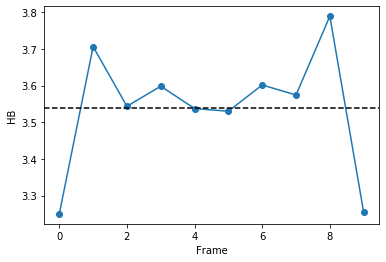

In [28]:
hb = np.loadtxt('hb-prof.dat')
# print(gr)
hb_per_wat = hb[:,1]/hb[:,2]*2

plt.plot(hb_per_wat, 'o-')
print(np.mean(hb_per_wat))
plt.axhline(np.mean(hb_per_wat), ls='--', color='k')

plt.ylabel('HB')
plt.xlabel('Frame')